In [ ]:
import numpy as np
from matplotlib.path import Path as plt_Path
import pandas as pd
import os
import matplotlib.pyplot as plt 
import warnings
import glob
import gc
from pyproj import Transformer
import json
import contextily as ctx
import holidays
warnings.filterwarnings("ignore")

# Process

In [2]:
path = r'..\\Chicago Divvy Bike\data'
all_files = glob.glob(os.path.join(path, "*divvy-tripdata*"))
df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
df["started_at"]=pd.to_datetime(df["started_at"],format='ISO8601')
df["ended_at"]=pd.to_datetime(df["ended_at"],format='ISO8601')
df=df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5860568 entries, 0 to 5860567
Data columns (total 13 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             object        
 1   rideable_type       object        
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  object        
 5   start_station_id    object        
 6   end_station_name    object        
 7   end_station_id      object        
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       object        
dtypes: datetime64[ns](2), float64(4), object(7)
memory usage: 581.3+ MB


In [3]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,C1D650626C8C899A,electric_bike,2024-01-12 15:30:27,2024-01-12 15:37:59,Wells St & Elm St,KA1504000135,Kingsbury St & Kinzie St,KA1503000043,41.903267,-87.634737,41.889177,-87.638506,member
1,EECD38BDB25BFCB0,electric_bike,2024-01-08 15:45:46,2024-01-08 15:52:59,Wells St & Elm St,KA1504000135,Kingsbury St & Kinzie St,KA1503000043,41.902937,-87.634440,41.889177,-87.638506,member
2,F4A9CE78061F17F7,electric_bike,2024-01-27 12:27:19,2024-01-27 12:35:19,Wells St & Elm St,KA1504000135,Kingsbury St & Kinzie St,KA1503000043,41.902951,-87.634470,41.889177,-87.638506,member
3,0A0D9E15EE50B171,classic_bike,2024-01-29 16:26:17,2024-01-29 16:56:06,Wells St & Randolph St,TA1305000030,Larrabee St & Webster Ave,13193,41.884295,-87.633963,41.921822,-87.644140,member
4,33FFC9805E3EFF9A,classic_bike,2024-01-31 05:43:23,2024-01-31 06:09:35,Lincoln Ave & Waveland Ave,13253,Kingsbury St & Kinzie St,KA1503000043,41.948797,-87.675278,41.889177,-87.638506,member


In [4]:
(df.isna().sum()/df.shape[0])*100

ride_id                0.000000
rideable_type          0.000000
started_at             0.000000
ended_at               0.000000
start_station_name    18.325033
start_station_id      18.325033
end_station_name      18.848907
end_station_id        18.848907
start_lat              0.000000
start_lng              0.000000
end_lat                0.123401
end_lng                0.123401
member_casual          0.000000
dtype: float64

In [5]:
df["rideable_type"].value_counts()

rideable_type
electric_bike       2980595
classic_bike        2735636
electric_scooter     144337
Name: count, dtype: int64

In [6]:
df["member_casual"].value_counts()

member_casual
member    3708910
casual    2151658
Name: count, dtype: int64

## Removing bad time dates

In [7]:
df = df.drop(df[df["started_at"]>df["ended_at"]].index)

In [8]:
(df["ended_at"]-df["started_at"]<np.timedelta64(pd.Timedelta("0 days 00:01:00"))).value_counts(normalize=True)*100

False    97.759465
True      2.240535
Name: proportion, dtype: float64

## Geographic data analysis

In [9]:
df[df["end_lat"].isna()].isna().sum()

ride_id                  0
rideable_type            0
started_at               0
ended_at                 0
start_station_name       0
start_station_id         0
end_station_name      7232
end_station_id        7232
start_lat                0
start_lng                0
end_lat               7232
end_lng               7232
member_casual            0
dtype: int64

In [10]:
df=df.dropna(subset="end_lat")

In [11]:
df.isna().sum()

ride_id                     0
rideable_type               0
started_at                  0
ended_at                    0
start_station_name    1073823
start_station_id      1073823
end_station_name      1097267
end_station_id        1097267
start_lat                   0
start_lng                   0
end_lat                     0
end_lng                     0
member_casual               0
dtype: int64

In [12]:
df[["start_lat","start_lng","end_lat","end_lng"]].describe()

,start_lat,start_lng,end_lat,end_lng
count,5.853109e+06,5.853109e+06,5.853109e+06,5.853109e+06
mean,4.190219e+01,-8.764623e+01,4.190258e+01,-8.764644e+01
std,4.473420e-02,2.748243e-02,5.598340e-02,1.136844e-01
min,4.164000e+01,-8.791000e+01,1.606000e+01,-1.440500e+02
25%,4.188096e+01,-8.766000e+01,4.188096e+01,-8.766000e+01
50%,4.189738e+01,-8.764182e+01,4.189776e+01,-8.764288e+01
75%,4.193000e+01,-8.762952e+01,4.193000e+01,-8.762954e+01
max,4.207000e+01,-8.752000e+01,8.796000e+01,1.525300e+02


In [13]:
def plot_map(df,lng,lat):
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
    x, y = transformer.transform(df[lng].to_numpy(), df[lat].to_numpy())
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.scatter(x, y, s=1, alpha=0.3, rasterized=True)
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y.min(), y.max())
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs="EPSG:3857")
    ax.set_title("Rides")
    plt.show()

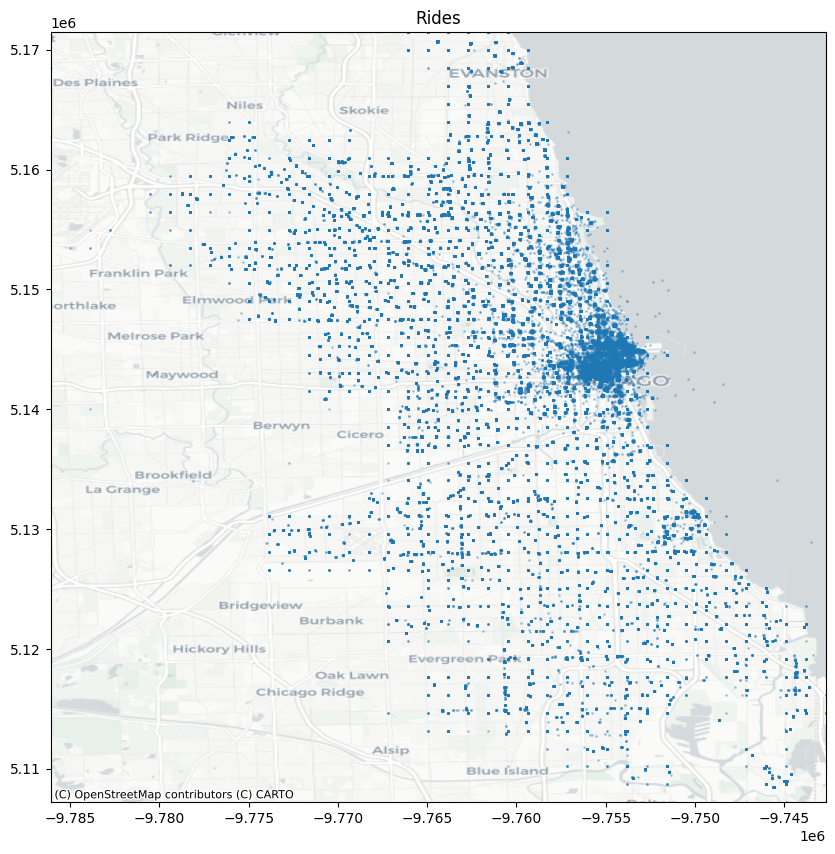

In [14]:
plot_map(df,"start_lng","start_lat")

In [15]:
def filter_chicago_bbox(df, lat_col="latitude", lon_col="longitude"):
    lat_min, lat_max = 41.64, 42.01
    lon_min, lon_max = -87.94, -87.52
    mask = (
        (df[lat_col] >= lat_min) & (df[lat_col] <= lat_max) &
        (df[lon_col] >= lon_min) & (df[lon_col] <= lon_max)
    )
    return df[mask].copy()

In [16]:
df_cord = filter_chicago_bbox(df[["start_lng","start_lat"]], lat_col="start_lat", lon_col="start_lng")

print(f"Before filtration: {len(df)}")
print(f"After filtration: {len(df_cord)}")

Before filtration: 5853109
After filtration: 5781847


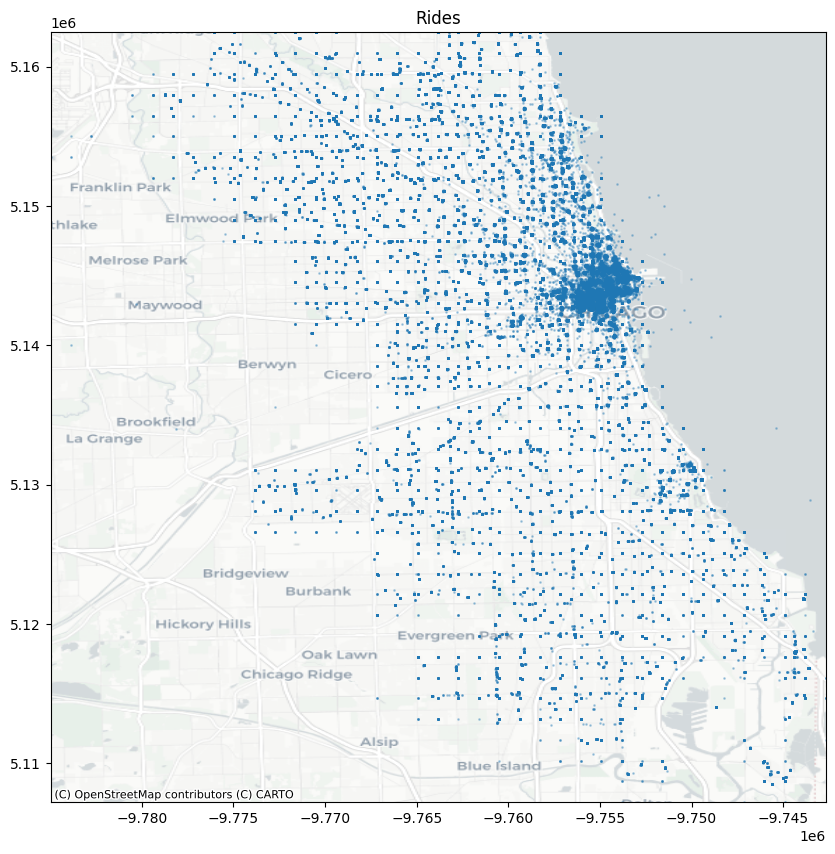

In [17]:
plot_map(df_cord,"start_lng","start_lat")

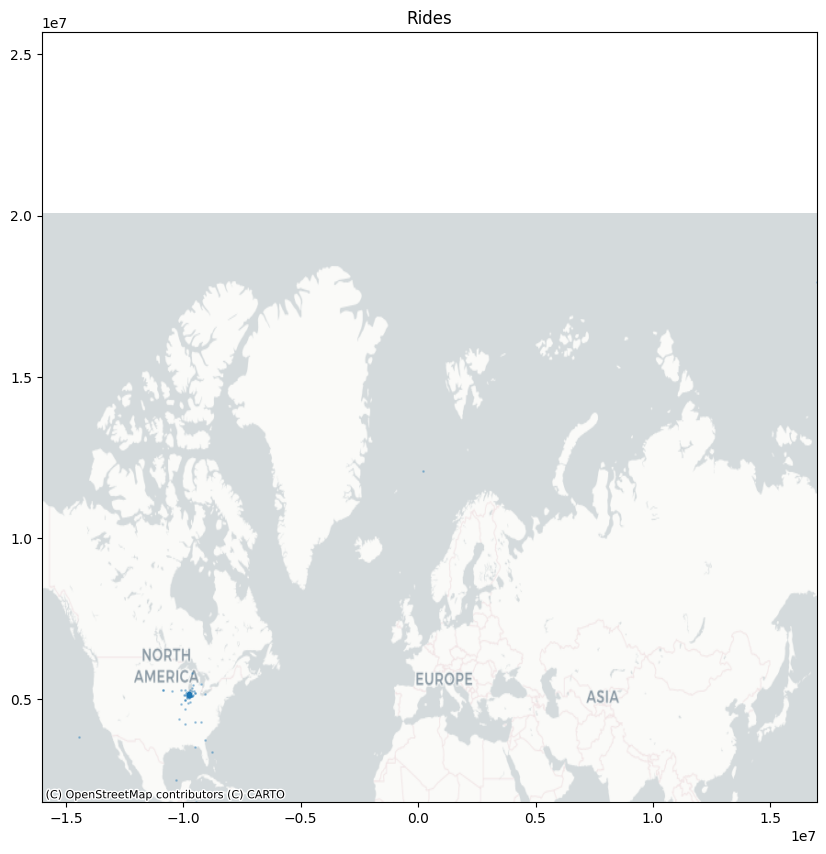

In [18]:
plot_map(df,"end_lng","end_lat")

In [19]:
df_cord = filter_chicago_bbox(df[["end_lng","end_lat"]], lat_col="end_lat", lon_col="end_lng")

print(f"Before filtration: {len(df)}")
print(f"After filtration: {len(df_cord)}")

Before filtration: 5853109
After filtration: 5781178


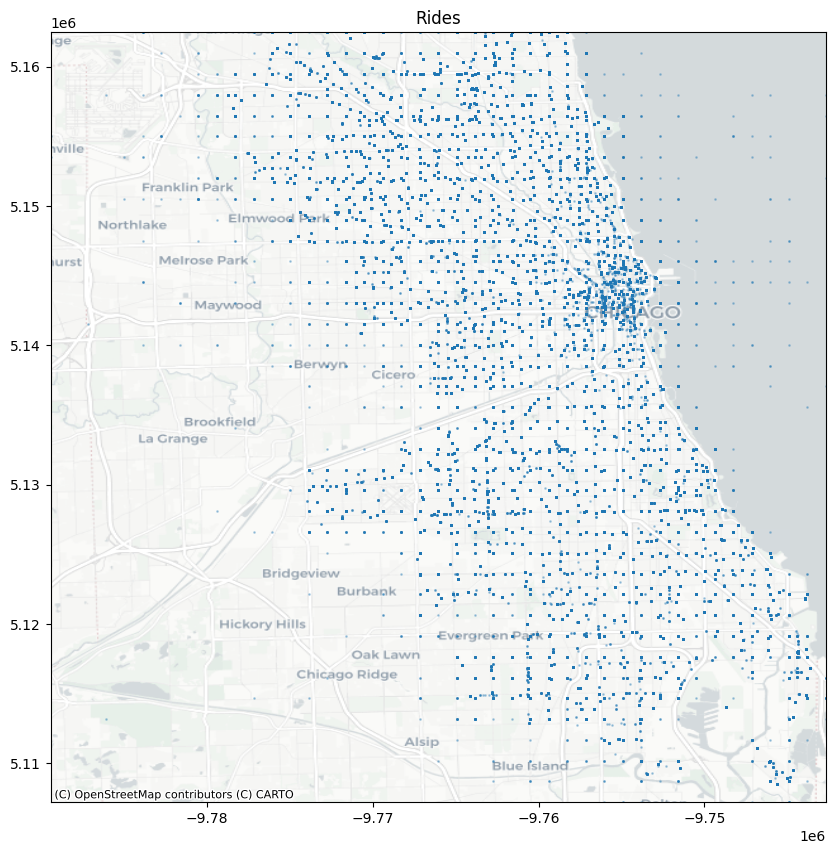

In [20]:
plot_map(df_cord,"end_lng","end_lat")

In [21]:
def polygons_from_geojson(geojson_path: str):
    with open(geojson_path, "r", encoding="utf-8") as f:
        gj = json.load(f)
    geoms = []
    gtype = gj["type"]
    feats = [gj] if gtype in ("Polygon", "MultiPolygon") else gj["features"]

    for feat in feats:
        geom = feat["geometry"] if "geometry" in feat else feat
        if geom["type"] == "Polygon":
            geoms.append(geom["coordinates"])
        elif geom["type"] == "MultiPolygon":
            geoms.extend(geom["coordinates"])
    return geoms
def mask_points_in_polygons_np(df, lat_col="latitude", lon_col="longitude",
                               geojson_path=None, chunk_size=1_000_000):
    polys = polygons_from_geojson(geojson_path)
    paths = []
    for poly in polys:
        outer = np.asarray(poly[0], dtype=float)
        vertices = [outer]
        codes = [([plt_Path.MOVETO] + [plt_Path.LINETO]*(len(outer)-2) + [plt_Path.CLOSEPOLY])]
        for hole in poly[1:]:
            hole = np.asarray(hole, dtype=float)
            vertices.append(hole)
            codes.append([plt_Path.MOVETO] + [plt_Path.LINETO]*(len(hole)-2) + [plt_Path.CLOSEPOLY])
        verts = np.vstack(vertices)
        codes = np.concatenate(codes)
        paths.append(plt_Path(verts, codes))
    x = df[lon_col].to_numpy(np.float64, copy=False)
    y = df[lat_col].to_numpy(np.float64, copy=False)
    n = len(df)
    mask = np.zeros(n, dtype=bool)
    for start in range(0, n, chunk_size):
        end = min(start + chunk_size, n)
        pts = np.column_stack([x[start:end], y[start:end]])
        inside_any = np.zeros(len(pts), dtype=bool)
        for p in paths:
            inside_any |= p.contains_points(pts)
        mask[start:end] = inside_any
    return mask

In [22]:
geo = "..\Chicago Divvy Bike\data\Boundaries_-_City_20250921.geojson"
m = mask_points_in_polygons_np(df_cord, "end_lat", "end_lng", geo, chunk_size=1_000_000)
df_land = df_cord[m]

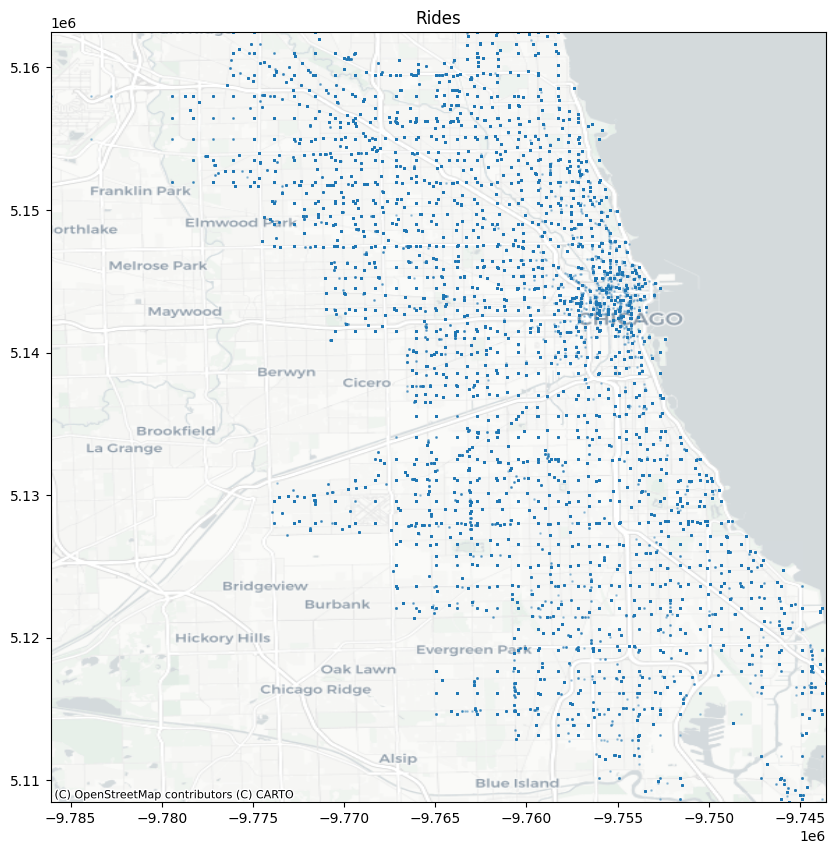

In [23]:
plot_map(df_land,"end_lng","end_lat")

In [24]:
del df_land
gc.collect()

9993

### Cleansing data located outside the Chicago area

In [25]:
df_cord = filter_chicago_bbox(df, lat_col="start_lat", lon_col="start_lng")
df_cord = filter_chicago_bbox(df_cord, lat_col="end_lat", lon_col="end_lng")
m = mask_points_in_polygons_np(df_cord, "start_lat", "start_lng", geo, chunk_size=1_000_000)
df_cord = df_cord[m]
m = mask_points_in_polygons_np(df_cord, "end_lat", "end_lng", geo, chunk_size=1_000_000)
df_cord = df_cord[m]

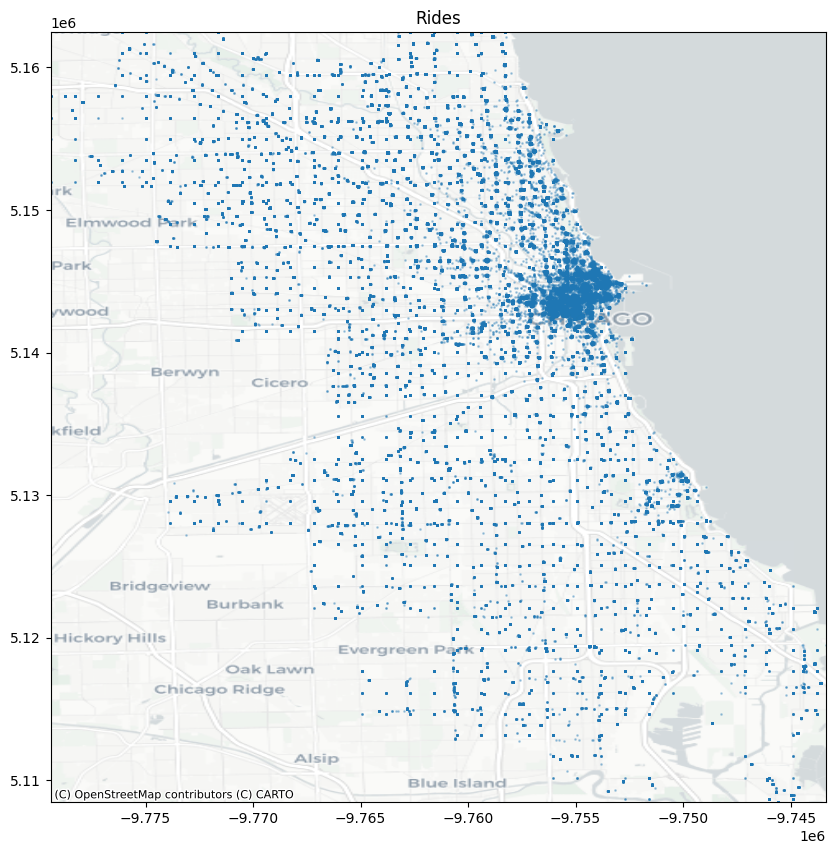

In [26]:
plot_map(df_cord,"start_lng","start_lat")

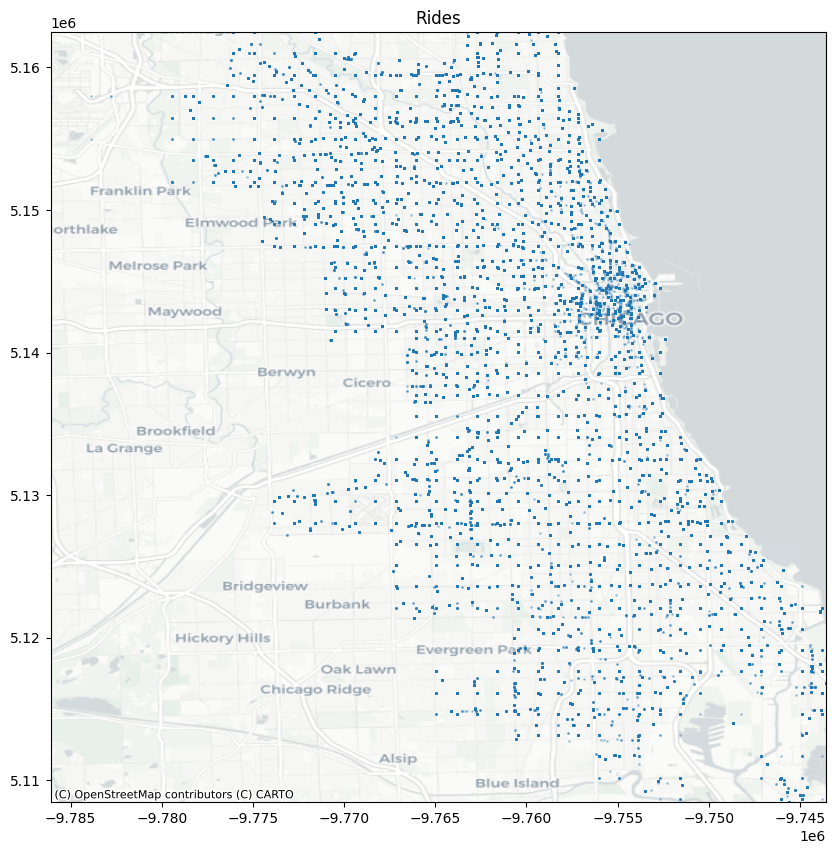

In [27]:
plot_map(df_cord,"end_lng","end_lat")

In [28]:
df_cord.describe()

,started_at,ended_at,start_lat,start_lng,end_lat,end_lng
count,5695621,5695621,5.695621e+06,5.695621e+06,5.695621e+06,5.695621e+06
mean,2024-07-17 08:15:13.288663552,2024-07-17 08:30:38.379680,4.190006e+01,-8.764588e+01,4.190044e+01,-8.764613e+01
min,2024-01-01 00:00:39,2024-01-01 00:04:20,4.164850e+01,-8.785000e+01,4.164850e+01,-8.791000e+01
25%,2024-05-20 16:22:19,2024-05-20 16:36:21,4.188033e+01,-8.765979e+01,4.188096e+01,-8.766000e+01
50%,2024-07-23 06:46:59.392000,2024-07-23 06:56:14.972000,4.189662e+01,-8.764155e+01,4.189675e+01,-8.764182e+01
75%,2024-09-18 07:51:03.094000128,2024-09-18 08:01:42.942000128,4.192871e+01,-8.762932e+01,4.192889e+01,-8.762952e+01
max,2024-12-31 23:56:49.854000,2024-12-31 23:59:43.221000,4.201000e+01,-8.752620e+01,4.201000e+01,-8.752823e+01
std,NaN,NaN,4.192636e-02,2.729583e-02,4.207882e-02,2.741528e-02


### Feature Extraction

In [29]:
df_cord["trip_duration"]=(df_cord["ended_at"]-df_cord["started_at"])/ pd.Timedelta(minutes=1)

In [30]:
df_cord["month"]=df_cord["started_at"].dt.month_name()

In [31]:
df_cord["day"]=df_cord["started_at"].dt.day_name()

In [32]:
def weekday_map(row):
    if row in ("Saturday","Sunday"):
        return "Weekend"
    else:
        return "Weekdays"

In [33]:
df_cord["day_of_week"]=df_cord["day"].map(lambda x: weekday_map(x))

In [34]:
def time_category(hour):
    if 0 <= hour <= 5:
        return "Night"
    elif 6 <= hour <= 10:
        return "Morning"
    elif 11 <= hour <= 15:
        return "Day"
    elif 16 <= hour <= 20:
        return "Evening"
    else:
        return "Late evening"
df_cord["time_of_day"] = df_cord["started_at"].dt.hour.map(time_category)

In [35]:
us_holidays = holidays.US(years=[2024], state="IL")
df_cord["is_holiday"] = df_cord["started_at"].dt.date.isin(us_holidays)
df_cord["holiday_name"] = df_cord["started_at"].dt.date.map(us_holidays.get)

In [36]:
def month_to_season(month):
    if month in ["December", "January", "February"]:
        return "Winter"
    elif month in ["March", "April", "May"]:
        return "Spring"
    elif month in ["June", "July", "August"]:
        return "Summer"
    else:
        return "Autumn"
df_cord["season"] = df_cord["month"].apply(month_to_season)

In [37]:
def haversine(lat1, lon1, lat2, lon2):
    R=6371.0
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi / 2.0)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

In [38]:
df_cord["trip_distance"] = haversine(
    df_cord["start_lat"].to_numpy(),
    df_cord["start_lng"].to_numpy(),
    df_cord["end_lat"].to_numpy(),
    df_cord["end_lng"].to_numpy()
)

In [39]:
df_cord.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,...,member_casual,trip_duration,month,day,day_of_week,time_of_day,is_holiday,holiday_name,season,trip_distance
0,C1D650626C8C899A,electric_bike,2024-01-12 15:30:27,2024-01-12 15:37:59,Wells St & Elm St,KA1504000135,Kingsbury St & Kinzie St,KA1503000043,41.903267,-87.634737,...,member,7.533333,January,Friday,Weekdays,Day,False,None,Winter,1.597552
1,EECD38BDB25BFCB0,electric_bike,2024-01-08 15:45:46,2024-01-08 15:52:59,Wells St & Elm St,KA1504000135,Kingsbury St & Kinzie St,KA1503000043,41.902937,-87.634440,...,member,7.216667,January,Monday,Weekdays,Day,False,None,Winter,1.566573
2,F4A9CE78061F17F7,electric_bike,2024-01-27 12:27:19,2024-01-27 12:35:19,Wells St & Elm St,KA1504000135,Kingsbury St & Kinzie St,KA1503000043,41.902951,-87.634470,...,member,8.000000,January,Saturday,Weekend,Day,False,None,Winter,1.567650
3,0A0D9E15EE50B171,classic_bike,2024-01-29 16:26:17,2024-01-29 16:56:06,Wells St & Randolph St,TA1305000030,Larrabee St & Webster Ave,13193,41.884295,-87.633963,...,member,29.816667,January,Monday,Weekdays,Evening,False,None,Winter,4.256963
4,33FFC9805E3EFF9A,classic_bike,2024-01-31 05:43:23,2024-01-31 06:09:35,Lincoln Ave & Waveland Ave,13253,Kingsbury St & Kinzie St,KA1503000043,41.948797,-87.675278,...,member,26.200000,January,Wednesday,Weekdays,Night,False,None,Winter,7.294281


### Finding outliers based on trip_duration and trip_distance

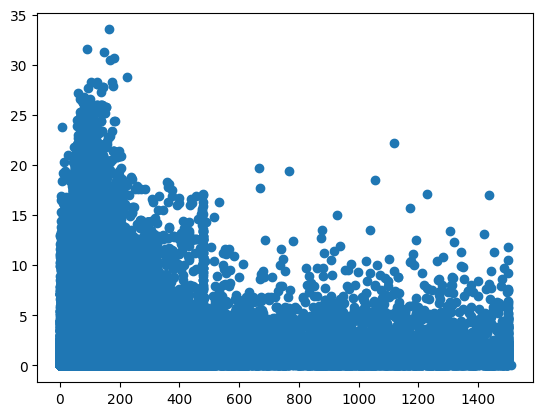

In [40]:
plt.scatter(df_cord["trip_duration"], df_cord["trip_distance"])

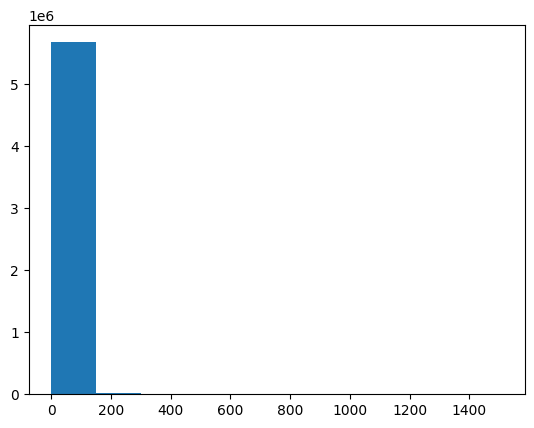

In [41]:
plt.hist(df_cord["trip_duration"])
plt.show()

In [42]:
df_cord[["trip_duration","trip_distance"]].describe()

,trip_duration,trip_distance
count,5.695621e+06,5.695621e+06
mean,1.541818e+01,2.127730e+00
std,3.288679e+01,1.918134e+00
min,0.000000e+00,0.000000e+00
25%,5.533333e+00,8.744669e-01
50%,9.666667e+00,1.563441e+00
75%,1.710812e+01,2.775061e+00
max,1.509367e+03,3.353885e+01


In [43]:
def find_outliers_IQR(df):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
   return outliers

In [44]:
find_outliers_IQR(df_cord["trip_duration"]).describe()

count    425015.000000
mean         71.612835
std         101.935530
min          34.470300
25%          39.750000
50%          48.412867
75%          69.339058
max        1509.366667
Name: trip_duration, dtype: float64

In [45]:
df_cord=df_cord.drop(df_cord[df_cord["trip_duration"]<1].index)
duration_log=df_cord["trip_duration"].map(lambda x: np.log(x))
index=find_outliers_IQR(duration_log).index
df_cord.loc[index]["trip_duration"].describe()

count    70319.000000
mean       175.682231
std        221.613271
min          1.000000
25%         97.968542
50%        118.362500
75%        163.145050
max       1509.366667
Name: trip_duration, dtype: float64

In [46]:
df_cord = df_cord[
    (df_cord["trip_duration"] >= 2) & 
    (df_cord["trip_duration"] <= 240)
]

In [47]:
df_cord["trip_duration"].describe()

count    5.451963e+06
mean     1.505910e+01
std      1.710512e+01
min      2.000000e+00
25%      5.977267e+00
50%      1.007225e+01
75%      1.755000e+01
max      2.400000e+02
Name: trip_duration, dtype: float64

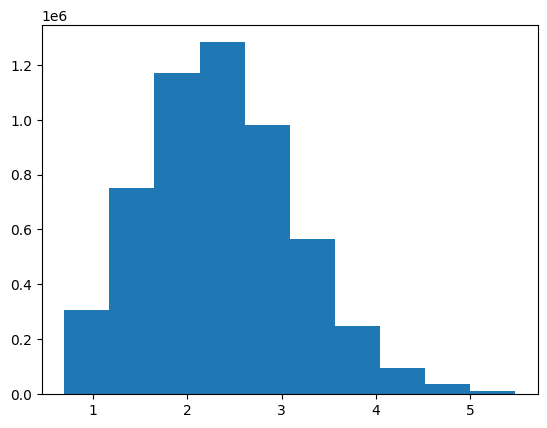

In [48]:
plt.hist(np.log(df_cord["trip_duration"]))
plt.show()

In [49]:
df_cord["trip_distance"].describe()

count    5.451963e+06
mean     2.211455e+00
std      1.912825e+00
min      0.000000e+00
25%      9.656972e-01
50%      1.633429e+00
75%      2.860809e+00
max      3.353885e+01
Name: trip_distance, dtype: float64

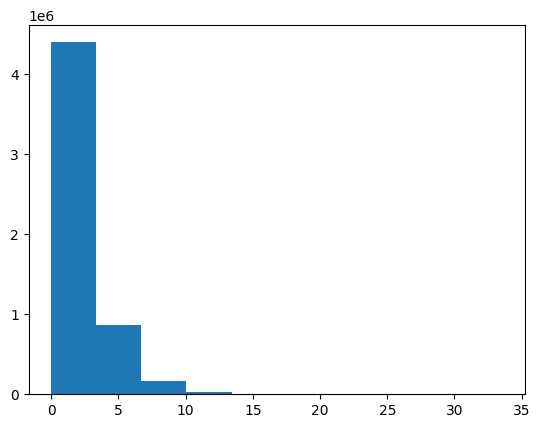

In [50]:
plt.hist(df_cord["trip_distance"])
plt.show()

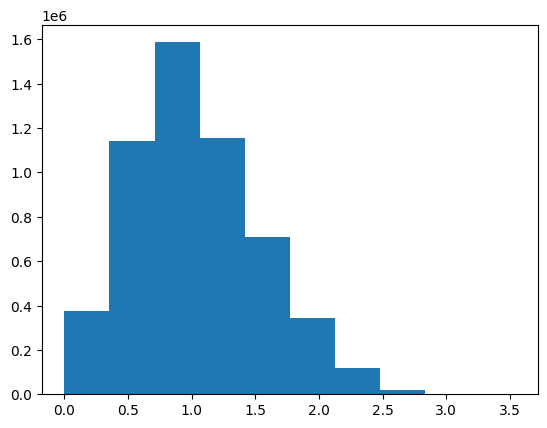

In [51]:
plt.hist(np.log1p(df_cord["trip_distance"]))
plt.show()

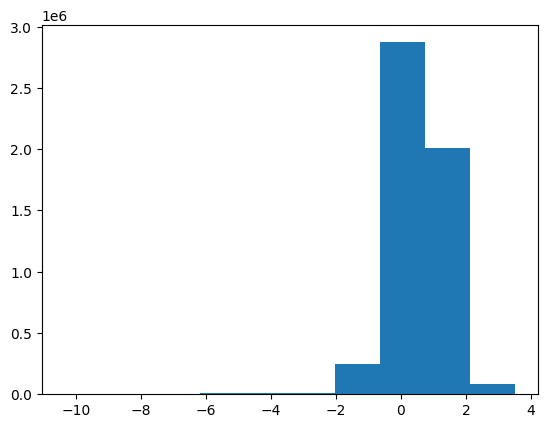

In [52]:
plt.hist(np.log(df_cord[df_cord["trip_distance"]>0]["trip_distance"]))
plt.show()

In [53]:
distance_log=df_cord["trip_distance"].map(lambda x: np.log1p(x))
index=find_outliers_IQR(distance_log).index
df_cord.loc[index]["trip_distance"].describe()

count    46519.000000
mean        11.470103
std          1.992459
min          9.627286
25%         10.196941
50%         10.857716
75%         11.972279
max         33.538851
Name: trip_distance, dtype: float64

In [54]:
distance_log=df_cord[df_cord["trip_distance"]>0]["trip_distance"].map(lambda x: np.log(x))
index=find_outliers_IQR(distance_log).index
df_cord.loc[index]["trip_distance"].describe()

count    46631.000000
mean         1.549030
std          4.729997
min          0.000032
25%          0.011730
50%          0.069854
75%          0.179926
max         33.538851
Name: trip_distance, dtype: float64

In [55]:
df_cord = df_cord[
    (df_cord["trip_distance"] == 0) | 
    ((df_cord["trip_distance"] >= 0.15) & (df_cord["trip_distance"] <= 15))
]
len(df_cord)

5420003

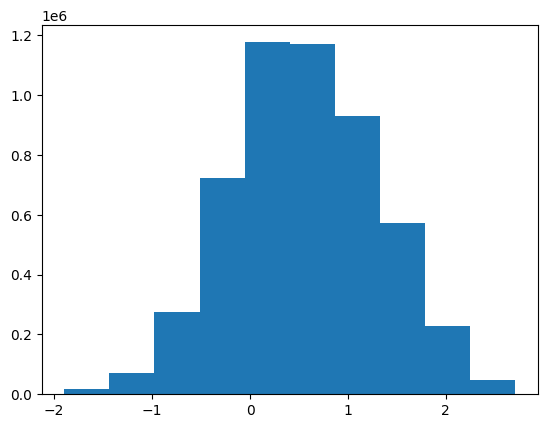

In [56]:
plt.hist(np.log(df_cord[df_cord["trip_distance"]>0]["trip_distance"]))
plt.show()

In [57]:
df_cord.describe()

,started_at,ended_at,start_lat,start_lng,end_lat,end_lng,trip_duration,trip_distance
count,5420003,5420003,5.420003e+06,5.420003e+06,5.420003e+06,5.420003e+06,5.420003e+06,5.420003e+06
mean,2024-07-17 17:19:28.313275392,2024-07-17 17:34:26.352926208,4.190022e+01,-8.764588e+01,4.190063e+01,-8.764614e+01,1.496733e+01,2.215661e+00
min,2024-01-01 00:00:39,2024-01-01 00:04:20,4.164850e+01,-8.785000e+01,4.164850e+01,-8.789000e+01,2.000000e+00,0.000000e+00
25%,2024-05-21 07:45:52.500000,2024-05-21 07:57:38.500000,4.188044e+01,-8.765979e+01,4.188096e+01,-8.766000e+01,5.975475e+00,9.766562e-01
50%,2024-07-23 17:02:08.470000128,2024-07-23 17:16:51.927000064,4.189662e+01,-8.764170e+01,4.189675e+01,-8.764182e+01,1.005387e+01,1.640644e+00
75%,2024-09-18 13:06:45.314000128,2024-09-18 13:21:38.795000064,4.192871e+01,-8.762933e+01,4.192889e+01,-8.762952e+01,1.747687e+01,2.867456e+00
max,2024-12-31 23:54:37.045000,2024-12-31 23:59:43.221000,4.201000e+01,-8.752620e+01,4.201000e+01,-8.752823e+01,2.399743e+02,1.499918e+01
std,NaN,NaN,4.170445e-02,2.705777e-02,4.186310e-02,2.718074e-02,1.693130e+01,1.880487e+00


### Travel speed analysis

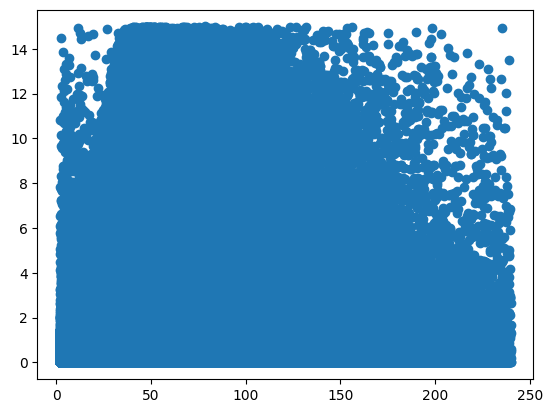

In [58]:
plt.scatter(df_cord["trip_duration"], df_cord["trip_distance"])

In [59]:
df_cord["speed"]=df_cord["trip_distance"]/(df_cord["trip_duration"]/60)
df_cord["speed"].describe()

count    5.420003e+06
mean     1.110968e+01
std      5.339013e+00
min      0.000000e+00
25%      7.975644e+00
50%      1.114351e+01
75%      1.446061e+01
max      3.294768e+02
Name: speed, dtype: float64

In [60]:
classic_bikes = df_cord[df_cord["rideable_type"] == "classic_bike"]
electric_bikes = df_cord[(df_cord["rideable_type"] == "electric_bike") | (df_cord["rideable_type"] == "electric_scooter")]

In [61]:
classic_bikes["speed"][classic_bikes["speed"]>0].describe()

count    2.494699e+06
mean     9.469536e+00
std      3.629433e+00
min      4.469742e-02
25%      7.339856e+00
50%      9.739856e+00
75%      1.191480e+01
max      3.294768e+02
Name: speed, dtype: float64

In [62]:
electric_bikes["speed"][electric_bikes["speed"]>0].describe()

count    2.717423e+06
mean     1.346528e+01
std      5.225029e+00
min      4.085410e-02
25%      1.023365e+01
50%      1.364997e+01
75%      1.690767e+01
max      2.885653e+02
Name: speed, dtype: float64

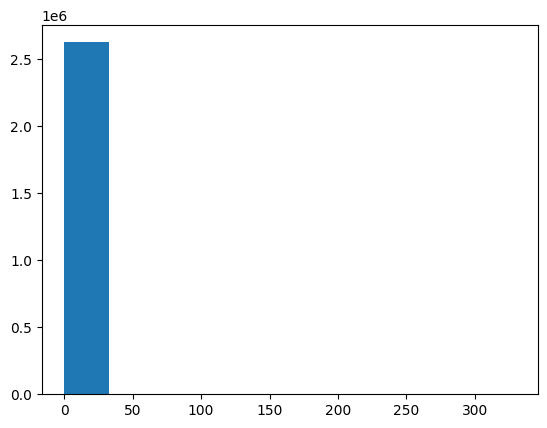

In [63]:
plt.hist(classic_bikes["speed"])
plt.show()

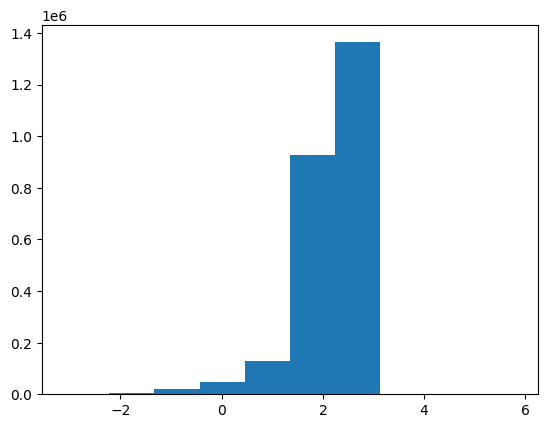

In [64]:
plt.hist(np.log(classic_bikes[classic_bikes["speed"]>0]["speed"]))
plt.show()

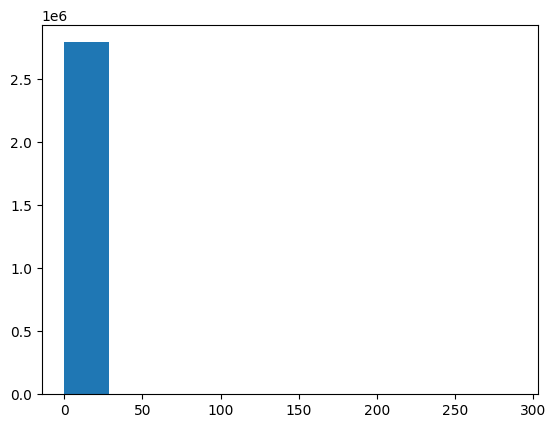

In [65]:
plt.hist(electric_bikes["speed"])
plt.show()

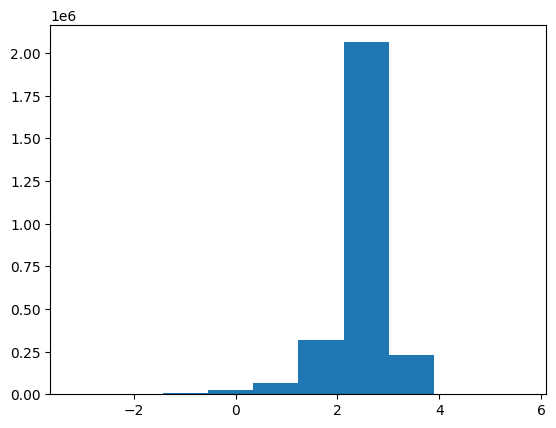

In [66]:
plt.hist(np.log(electric_bikes[electric_bikes["speed"]>0]["speed"]))
plt.show()

In [67]:
speed_log=classic_bikes["speed"].map(lambda x: np.log1p(x))
index=find_outliers_IQR(speed_log).index
classic_bikes.loc[index]["speed"].describe()

count    263246.000000
mean          0.757733
std           1.537355
min           0.000000
25%           0.000000
50%           0.228459
75%           1.476033
max         329.476794
Name: speed, dtype: float64

In [68]:
speed_log=classic_bikes[classic_bikes["speed"]>0]["speed"].map(lambda x: np.log(x))
index=find_outliers_IQR(speed_log).index
classic_bikes.loc[index]["speed"].describe()

count    184729.000000
mean          1.918247
std           1.785351
min           0.044697
25%           1.021731
50%           1.923567
75%           2.787576
max         329.476794
Name: speed, dtype: float64

In [69]:
speed_log=electric_bikes["speed"].map(lambda x: np.log1p(x))
index=find_outliers_IQR(speed_log).index
electric_bikes.loc[index]["speed"].describe()

count    214861.000000
mean          1.723926
std           4.729792
min           0.000000
25%           0.000000
50%           1.104119
75%           2.795841
max         288.565282
Name: speed, dtype: float64

In [70]:
speed_log=electric_bikes[electric_bikes["speed"]>0]["speed"].map(lambda x: np.log(x))
index=find_outliers_IQR(speed_log).index
electric_bikes.loc[index]["speed"].describe()

count    164799.000000
mean          3.087951
std           5.278386
min           0.040854
25%           1.570696
50%           2.842208
75%           3.923963
max         288.565282
Name: speed, dtype: float64

In [71]:
classic_bikes = classic_bikes[
    (classic_bikes["speed"] == 0) | 
    ((classic_bikes["speed"] >= 3.5) & (classic_bikes["speed"] <= 32))
]
electric_bikes = electric_bikes[
    (electric_bikes["speed"] == 0) | 
    ((electric_bikes["speed"] >= 5) & (electric_bikes["speed"] <= 45))
]

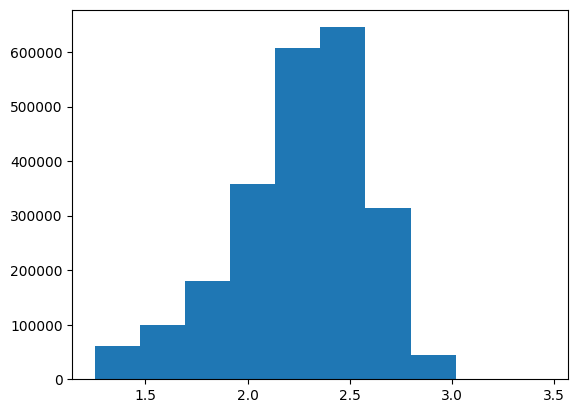

In [72]:
plt.hist(np.log(classic_bikes[classic_bikes["speed"]>0]["speed"]))
plt.show()

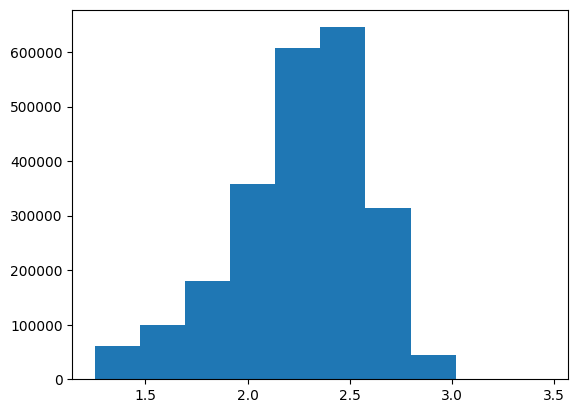

In [73]:
plt.hist(np.log(classic_bikes[classic_bikes["speed"]>0]["speed"]))
plt.show()

In [74]:
df_cord_2 = pd.concat([classic_bikes, electric_bikes], axis=0)

In [75]:
df_cord_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5065571 entries, 3 to 5860567
Data columns (total 23 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             object        
 1   rideable_type       object        
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  object        
 5   start_station_id    object        
 6   end_station_name    object        
 7   end_station_id      object        
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       object        
 13  trip_duration       float64       
 14  month               object        
 15  day                 object        
 16  day_of_week         object        
 17  time_of_day         object        
 18  is_holiday          bool          
 19  holiday_name        object        
 20  season 

In [76]:
df_cord_2.isna().sum()

ride_id                     0
rideable_type               0
started_at                  0
ended_at                    0
start_station_name     854032
start_station_id       854032
end_station_name       835590
end_station_id         835590
start_lat                   0
start_lng                   0
end_lat                     0
end_lng                     0
member_casual               0
trip_duration               0
month                       0
day                         0
day_of_week                 0
time_of_day                 0
is_holiday                  0
holiday_name          4921233
season                      0
trip_distance               0
speed                       0
dtype: int64

In [77]:
df_cord_2.to_csv("..\\Chicago Divvy Bike\data\\Data_Analysis.csv", index=True, index_label="record_id")